Insper

## Supercomputação - Dask

## 1. Setup inicial e obtendo os dados

In [ ]:
!pip install dask[complete]

In [5]:
!pip install graphviz

In [1]:
import pandas as pd
import numpy as np
from dask import delayed
from time import sleep

In [ ]:
!wget https://storage.googleapis.com/dask-tutorial-data/nycflights.tar.gz
!mkdir data
!tar -xvzf nycflights.tar.gz -C data

## 1.1 Usando Pandas para obter o maior atraso dentre todos os voos

In [6]:
# Qual é o maior atraso (DepDelay) dentre todos os voos (todos os arquivos)?
%%time

import glob

lista = []

filenames = glob.glob("data/nycflights/*.csv")

for filename in filenames:
    df = pd.read_csv(filename)
    lista.append(df.DepDelay.max())

max(lista)

CPU times: user 5.24 s, sys: 537 ms, total: 5.78 s
Wall time: 6.1 s


1435.0

## 2. Usando Dask Delayed para obter o maior atraso dentre todos os voos

In [10]:
# Qual é o maior atraso (DepDelay) dentre todos os voos (todos os arquivos)?
%%time

import glob
lista = []

filenames = glob.glob("data/nycflights/*.csv")

for filename in filenames:
    df = dask.delayed(pd.read_csv)(filename)
    lista.append(df.DepDelay.max())


final_max = dask.delayed(max)(lista)
final_max.compute()

CPU times: user 7.72 s, sys: 165 ms, total: 7.89 s
Wall time: 4.91 s


1435.0

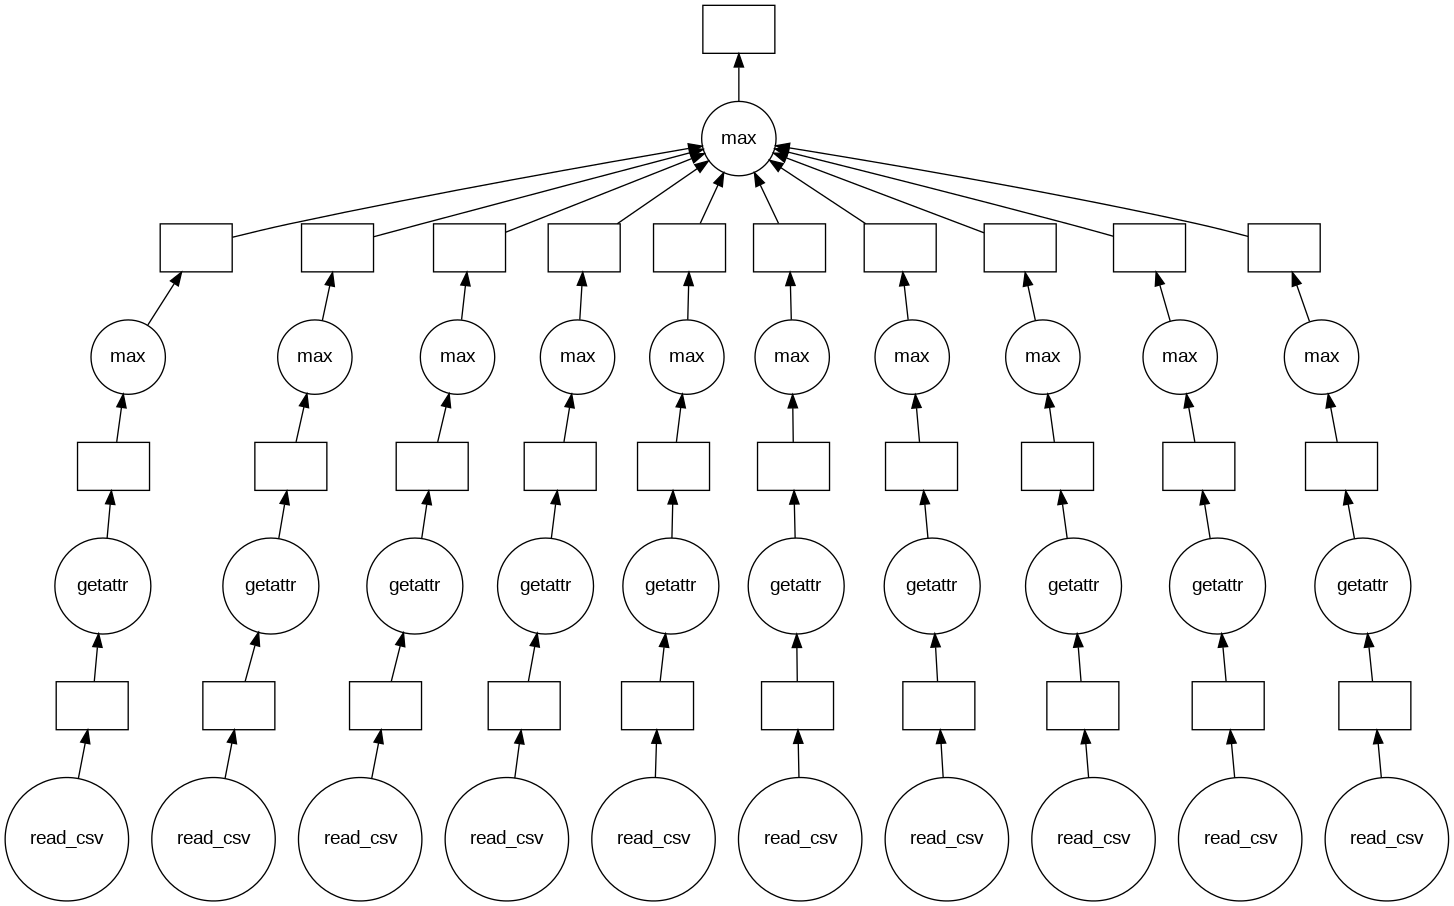

In [11]:
final_max.visualize()

In [12]:
%%time
final_max.compute()

CPU times: user 7.9 s, sys: 171 ms, total: 8.07 s
Wall time: 4.68 s


1435.0

## 3. Usando Dask DataFrames

In [13]:
import dask.dataframe as ddf

In [17]:
%%time

dados = ddf.read_csv("data/nycflights/*.csv")
dados['DepDelay'].max().compute()

CPU times: user 3.46 s, sys: 118 ms, total: 3.58 s
Wall time: 2.21 s


1435.0

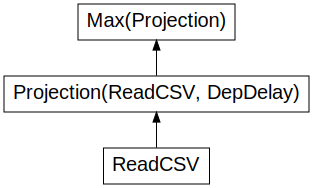

In [16]:
# Maior atraso?
dados['DepDelay'].max().visualize()

In [18]:
# Maior atraso por origem?
dados.groupby('Origin').DepDelay.max().compute()


,DepDelay
Origin,
EWR,1134.0
JFK,1435.0
LGA,1435.0


Obter os voos não cancelados

Obter a média e o desvio padrão dos atrasos dos voos não cancelados

In [19]:
df = ddf.read_csv("data/nycflights/*.csv")

In [20]:
# Primeiras linhas
df.head()

,Year,Month,DayofMonth,DayOfWeek,DepTime,CRSDepTime,ArrTime,CRSArrTime,UniqueCarrier,FlightNum,...,AirTime,ArrDelay,DepDelay,Origin,Dest,Distance,TaxiIn,TaxiOut,Cancelled,Diverted
0,1990,1,1,1,1621.0,1540,1747.0,1701,US,33,...,NaN,46.0,41.0,EWR,PIT,319.0,NaN,NaN,0,0
1,1990,1,2,2,1547.0,1540,1700.0,1701,US,33,...,NaN,-1.0,7.0,EWR,PIT,319.0,NaN,NaN,0,0
2,1990,1,3,3,1546.0,1540,1710.0,1701,US,33,...,NaN,9.0,6.0,EWR,PIT,319.0,NaN,NaN,0,0
3,1990,1,4,4,1542.0,1540,1710.0,1701,US,33,...,NaN,9.0,2.0,EWR,PIT,319.0,NaN,NaN,0,0
4,1990,1,5,5,1549.0,1540,1706.0,1701,US,33,...,NaN,5.0,9.0,EWR,PIT,319.0,NaN,NaN,0,0


In [21]:
# Últimas linhas
df.tail()

ValueError: Mismatched dtypes found in `pd.read_csv`/`pd.read_table`.

+----------------+---------+----------+
| Column         | Found   | Expected |
+----------------+---------+----------+
| CRSElapsedTime | float64 | int64    |
| TailNum        | object  | float64  |
+----------------+---------+----------+

The following columns also raised exceptions on conversion:

- TailNum
  ValueError("could not convert string to float: 'N54711'")

Usually this is due to dask's dtype inference failing, and
*may* be fixed by specifying dtypes manually by adding:

dtype={'CRSElapsedTime': 'float64',
       'TailNum': 'object'}

to the call to `read_csv`/`read_table`.


Ao contrário do pandas.read_csv, que lê o arquivo inteiro antes de inferir os tipos de dados, dask.dataframe.read_csv lê apenas uma amostra do início do arquivo (ou do primeiro arquivo, se estiver usando um glob). Esses tipos de dados inferidos são então aplicados ao ler todas as partições.

In [22]:
df = ddf.read_csv("data/nycflights/*.csv",
                  dtype = {"TailNum": str,
                           "CRSElapsedTime": float,
                           "Cancelled": bool})

In [23]:
non_cancelled = df[~df.Cancelled]

In [24]:
mean_delay = non_cancelled.DepDelay.mean()
std_delay = non_cancelled.DepDelay.std()

In [25]:
%%time

mean_delay.compute()

CPU times: user 3.74 s, sys: 247 ms, total: 3.98 s
Wall time: 3.13 s


9.206602541321965

In [26]:
%%time

std_delay.compute()

CPU times: user 3.78 s, sys: 126 ms, total: 3.9 s
Wall time: 2.13 s


28.974539774551456

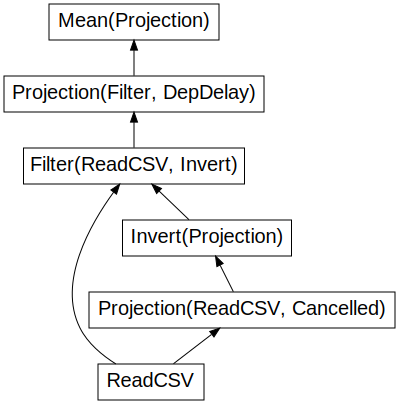

In [27]:
mean_delay.visualize()

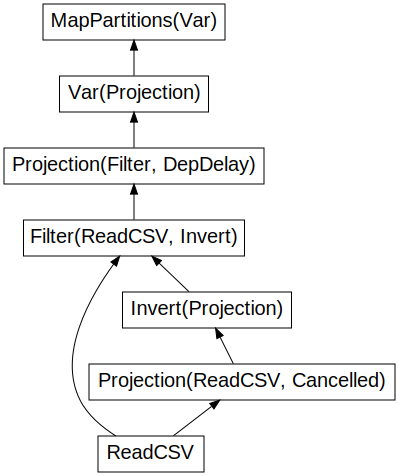

In [28]:
std_delay.visualize()

In [29]:
import dask

In [30]:
mean_delay, std_delay = dask.compute(mean_delay, std_delay)

In [31]:
print(mean_delay)
print(std_delay)

9.206602541321965
28.974539774551456


## 4. Reescrevendo nosso primeiro exemplo com _futures_

Uso comum:

```python
def process_file(filename):
    data = read_a_file(filename)
    data = do_a_transformation(data)
    destination = f"results/{filename}"
    write_out_data(data, destination)
    return destination

futures = []
for filename in filenames:
    future = client.submit(process_file, filename)
    futures.append(future)

futures

```

In [32]:
from time import sleep

def inc(x):
    sleep(1)
    return x + 1

def double(x):
    sleep(2)
    return 2 * x

def add(x, y):
    sleep(1)
    return x + y

In [33]:
# Iniciando um cluster dask com 4 executores
from dask.distributed import Client

client = Client(n_workers=4)
client

INFO:distributed.http.proxy:To route to workers diagnostics web server please install jupyter-server-proxy: python -m pip install jupyter-server-proxy
INFO:distributed.scheduler:State start
INFO:distributed.scheduler:  Scheduler at:     tcp://127.0.0.1:45825
INFO:distributed.scheduler:  dashboard at:  http://127.0.0.1:8787/status
INFO:distributed.scheduler:Registering Worker plugin shuffle
INFO:distributed.nanny:        Start Nanny at: 'tcp://127.0.0.1:45935'
INFO:distributed.nanny:        Start Nanny at: 'tcp://127.0.0.1:34095'
INFO:distributed.nanny:        Start Nanny at: 'tcp://127.0.0.1:45049'
INFO:distributed.nanny:        Start Nanny at: 'tcp://127.0.0.1:41419'
INFO:distributed.scheduler:Register worker <WorkerState 'tcp://127.0.0.1:46473', name: 1, status: init, memory: 0, processing: 0>
INFO:distributed.scheduler:Starting worker compute stream, tcp://127.0.0.1:46473
INFO:distributed.core:Starting established connection to tcp://127.0.0.1:33820
INFO:distributed.scheduler:Regist

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://127.0.0.1:8787/status,
Dashboard: http://127.0.0.1:8787/status,Workers: 4
Total threads: 4,Total memory: 12.67 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:45825,Workers: 4
Dashboard: http://127.0.0.1:8787/status,Total threads: 4
Started: Just now,Total memory: 12.67 GiB
Comm: tcp://127.0.0.1:42159,Total threads: 1
Dashboard: http://127.0.0.1:43429/status,Memory: 3.17 GiB
Nanny: tcp://127.0.0.1:45935,


Rodando localmente

In [34]:
double(9)

18

Ou podemos enviá-los para execução remota com Dask. Isso retorna imediatamente um futuro que aponta para a computação em andamento e, eventualmente, para o resultado armazenado.

In [35]:
future = client.submit(double, 9)
future

<Future: pending, key: double-3f092f9fe9ed2814427585034d38a487>

In [36]:
# E qual é o resultado?
future.result()

18

In [39]:
future_x = client.submit(inc, 1)
future_y = client.submit(double, 2)
future_z = client.submit(add, future_x, future_y)
future_z

<Future: pending, key: add-d7feb98468c0b9352d26952ef5d735f2>

In [40]:
future_z.result()

6

**Por que usar Futures?**

A API de futuros oferece um estilo de envio de trabalho que pode facilmente emular o paradigma mapear/reduzir. Se isso lhe é familiar, então os futuros podem ser o ponto de entrada mais simples no Dask.

O outro grande benefício dos futuros é que os resultados intermediários, representados pelos futuros, podem ser passados para novas tarefas sem a necessidade de extrair dados localmente do cluster. Novas operações podem ser configuradas para trabalhar na produção de trabalhos anteriores que ainda nem começaram.

## 5. [Exercícios] Cálculos em cima de Dask DataFrames

Continue utilizando os arquivos "data/nycflights/*.csv". Resolva as seguintes questões:

  a. Qual é o atraso Médio na Chegada por Transportadora

  b. Top 5 Rotas mais Curtas: rotas com a menor distância média

  c. Dias da Semana com Mais Voos

  d. Identificar Voos com Maior Atraso de Chegada

  e. Análise de Correlação entre Atraso na Partida e Chegada
